In [130]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [131]:
df = pd.read_csv("https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv")

In [132]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [133]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [134]:
# Start by doing the WRONG thing - trying to predict the price itself
series = df["close"].values.reshape(-1, 1)

In [135]:
# Normalize the data
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [136]:
T = 20
D = 1
X = []
Y = []

for t in range(len(series) - T):
  x = series[t:t+T]
  y = series[t+T]
  X.append(x)
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D, where D = 1
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print(f"X.shape: {X.shape}, Y.shape: {Y.shape}")

X.shape: (1239, 20, 1), Y.shape: (1239, 1)


In [137]:
# try autoregressive RNN model
class StockLSTM(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(StockLSTM, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    self.rnn = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first=True
    )

    self.fc = nn.Linear(self.M, self.K)
  
  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # get RNN unit output
    out, _ = self.rnn(X, (h0, c0))

    # we only want h(T) at the final time step
    out = self.fc(out[:, -1, :])
    return out

In [138]:
model = StockLSTM(n_inputs=1, n_hidden=5, n_rnnlayers=1, n_outputs=1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


StockLSTM(
  (rnn): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [139]:
# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [140]:
# Training
def full_gd(model, criterion, optimizer, Xtrain, Ytrain, Xtest, Ytest, epochs=200):

  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for i in range(epochs):

    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward Pass
    outputs = model(Xtrain)
    loss = criterion(outputs, Ytrain)

    # Backward and Optimize
    loss.backward()
    optimizer.step()
    train_losses[i] = loss.item()

    # Evaluation
    test_outputs = model(Xtest)
    test_loss = criterion(test_outputs, Ytest)
    test_losses[i] = test_loss.item()

    if (i+1) % 5 == 0:
      print(f"Epoch: {i+1}/{epochs}, Train Loss:{train_losses[i]:.4f}, Test Loss:{test_losses[i]:.4f}")
  
  return train_losses, test_losses

In [141]:
from sklearn.model_selection import train_test_split
# Shuffling would not make sense because a real forecasting model has to predict
# the future, it can't train on the points within the future.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.5, shuffle=False)
# Checking whether train_test_split function works as expected
np.allclose(Xtrain, X[:N//2]) # True

True

In [142]:
# Make inputs and targets
Xtrain = torch.from_numpy(Xtrain.astype(np.float32)).to(device)
Ytrain = torch.from_numpy(Ytrain.astype(np.float32)).to(device)
Xtest = torch.from_numpy(Xtest.astype(np.float32)).to(device)
Ytest = torch.from_numpy(Ytest.astype(np.float32)).to(device)

In [143]:
train_losses, test_losses = full_gd(model, criterion, optimizer, Xtrain, Ytrain, Xtest, Ytest)

Epoch: 5/200, Train Loss:0.2279, Test Loss:0.7215
Epoch: 10/200, Train Loss:0.1021, Test Loss:0.8303
Epoch: 15/200, Train Loss:0.0293, Test Loss:0.2398
Epoch: 20/200, Train Loss:0.0152, Test Loss:0.0710
Epoch: 25/200, Train Loss:0.0160, Test Loss:0.0366
Epoch: 30/200, Train Loss:0.0075, Test Loss:0.0385
Epoch: 35/200, Train Loss:0.0099, Test Loss:0.0672
Epoch: 40/200, Train Loss:0.0071, Test Loss:0.0333
Epoch: 45/200, Train Loss:0.0074, Test Loss:0.0280
Epoch: 50/200, Train Loss:0.0061, Test Loss:0.0208
Epoch: 55/200, Train Loss:0.0063, Test Loss:0.0225
Epoch: 60/200, Train Loss:0.0059, Test Loss:0.0185
Epoch: 65/200, Train Loss:0.0059, Test Loss:0.0199
Epoch: 70/200, Train Loss:0.0057, Test Loss:0.0246
Epoch: 75/200, Train Loss:0.0057, Test Loss:0.0259
Epoch: 80/200, Train Loss:0.0056, Test Loss:0.0220
Epoch: 85/200, Train Loss:0.0056, Test Loss:0.0211
Epoch: 90/200, Train Loss:0.0055, Test Loss:0.0225
Epoch: 95/200, Train Loss:0.0055, Test Loss:0.0222
Epoch: 100/200, Train Loss:0.005

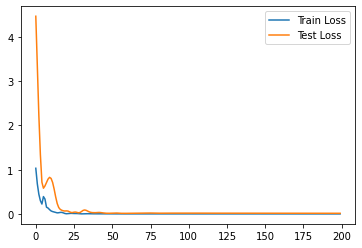

In [144]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend();

In [145]:
# One step forecast using true targets
predictions = []
# Index of first validation input
i = 0

X_on_device = torch.from_numpy(X.astype(np.float32)).to(device)

while len(predictions) < len(Ytest):
  input_ = X_on_device[i].reshape(1, T, 1)
  p = model(input_)[0, 0].item()
  i += 1

  predictions.append(p)

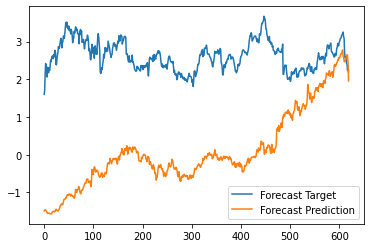

In [146]:
plt.plot(Ytest.cpu().numpy(), label='Forecast Target')
plt.plot(predictions, label='Forecast Prediction')
plt.legend();

In [147]:
# Forecast Future Values (use only self-predictions for making future predictions)
predictions = []

# last train input
# last_x = torch.from_numpy(X[-N//2])
# last_x = torch.from_numpy(X[-N//2].astype(np.float32))
last_x = Xtest[0].view(T)

while len(predictions) < len(Ytest):
  input_ = last_x.reshape(1, T, 1)
  p = model(input_)
  # [0, 0] -> 1 x 1 array -> scalar

  predictions.append(p[0, 0].item())

  # make the new input 
  last_x = torch.cat((last_x[1:], p[0]))

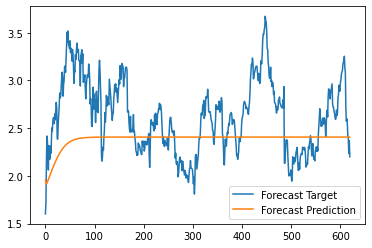

In [148]:
plt.plot(Ytest.cpu().numpy(), label='Forecast Target')
plt.plot(predictions, label='Forecast Prediction')
plt.legend();

# Stock Returns

In [149]:
# Calculate returns by first shifting the data
df["prev_close"] = df["close"].shift(1)

In [150]:
df.head()

,date,open,high,low,close,volume,Name,prev_close
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [151]:
df["return"] = (df["close"] - df["prev_close"]) / df["prev_close"]

In [152]:
df.head()

,date,open,high,low,close,volume,Name,prev_close,return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


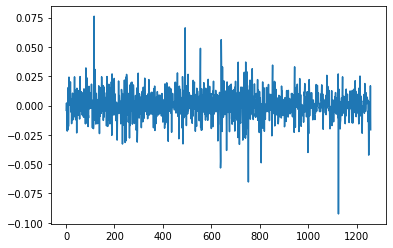

In [153]:
plt.plot(df["return"]);

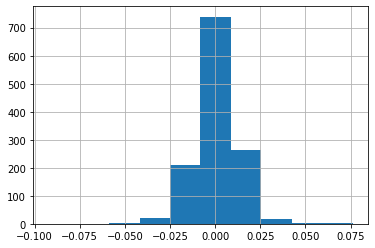

In [155]:
df["return"].hist();

In [156]:
df["return"].values[0]

nan

In [183]:
series = df["return"].values[1:].reshape(-1, 1)
# Normalize the data
scaler = StandardScaler()
scaler.fit(series[:len(series)//2])
series = scaler.transform(series).flatten()

In [184]:
T = 20
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  y = series[t+T]
  X.append(x)
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print(f"X.shape: {X.shape}, Y.shape: {Y.shape}")

X.shape: (1238, 20, 1), Y.shape: (1238, 1)


In [185]:
model = StockLSTM(n_inputs=1, n_hidden=5, n_rnnlayers=1, n_outputs=1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


StockLSTM(
  (rnn): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [186]:
# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [187]:
from sklearn.model_selection import train_test_split
# Shuffling would not make sense because a real forecasting model has to predict
# the future, it can't train on the points within the future.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.5, shuffle=False)
# Checking whether train_test_split function works as expected
np.allclose(Xtrain, X[:N//2]) # True

True

In [188]:
# Make inputs and targets
Xtrain = torch.from_numpy(Xtrain.astype(np.float32)).to(device)
Ytrain = torch.from_numpy(Ytrain.astype(np.float32)).to(device)
Xtest = torch.from_numpy(Xtest.astype(np.float32)).to(device)
Ytest = torch.from_numpy(Ytest.astype(np.float32)).to(device)

In [189]:
train_losses, test_losses = full_gd(model, criterion, optimizer, Xtrain, Ytrain, Xtest, Ytest, 600)

Epoch: 5/600, Train Loss:1.0561, Test Loss:1.0692
Epoch: 10/600, Train Loss:1.0537, Test Loss:1.0804
Epoch: 15/600, Train Loss:1.0489, Test Loss:1.0700
Epoch: 20/600, Train Loss:1.0416, Test Loss:1.0816
Epoch: 25/600, Train Loss:1.0330, Test Loss:1.0971
Epoch: 30/600, Train Loss:1.0287, Test Loss:1.0816
Epoch: 35/600, Train Loss:1.0188, Test Loss:1.1068
Epoch: 40/600, Train Loss:1.0103, Test Loss:1.1245
Epoch: 45/600, Train Loss:1.0190, Test Loss:1.1169
Epoch: 50/600, Train Loss:0.9977, Test Loss:1.1548
Epoch: 55/600, Train Loss:0.9814, Test Loss:1.1947
Epoch: 60/600, Train Loss:0.9529, Test Loss:1.1943
Epoch: 65/600, Train Loss:0.9409, Test Loss:1.2893
Epoch: 70/600, Train Loss:0.9755, Test Loss:1.1883
Epoch: 75/600, Train Loss:0.9646, Test Loss:1.2216
Epoch: 80/600, Train Loss:0.9576, Test Loss:1.2329
Epoch: 85/600, Train Loss:0.9494, Test Loss:1.2346
Epoch: 90/600, Train Loss:0.9418, Test Loss:1.2271
Epoch: 95/600, Train Loss:0.9305, Test Loss:1.2376
Epoch: 100/600, Train Loss:0.941

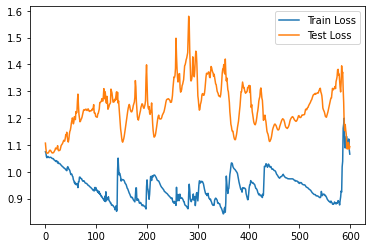

In [190]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend();

In [191]:
# One step forecast using true targets
predictions = []
# Index of first validation input
i = 0

X_on_device = torch.from_numpy(X.astype(np.float32)).to(device)

while len(predictions) < len(Ytest):
  input_ = X_on_device[i].reshape(1, T, 1)
  p = model(input_)[0, 0].item()
  i += 1

  predictions.append(p)

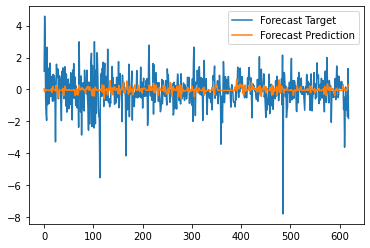

In [192]:
plt.plot(Ytest.cpu().numpy(), label='Forecast Target')
plt.plot(predictions, label='Forecast Prediction')
plt.legend();

In [193]:
# Forecast Future Values (use only self-predictions for making future predictions)
predictions = []

# last train input
# last_x = torch.from_numpy(X[-N//2])
# last_x = torch.from_numpy(X[-N//2].astype(np.float32))
last_x = Xtest[0].view(T)

while len(predictions) < len(Ytest):
  input_ = last_x.reshape(1, T, 1)
  p = model(input_)
  # [0, 0] -> 1 x 1 array -> scalar

  predictions.append(p[0, 0].item())

  # make the new input 
  last_x = torch.cat((last_x[1:], p[0]))

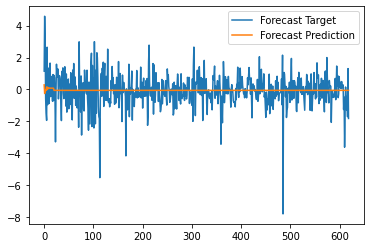

In [194]:
plt.plot(Ytest.cpu().numpy(), label='Forecast Target')
plt.plot(predictions, label='Forecast Prediction')
plt.legend();

# Binary Classification

In [195]:
# Turn the full data into numpy arrays
# Not yet in the final X format

input_data = df[["open", "high", "low", "close", "volume"]].values
targets = df["return"].values

In [196]:
# Now make the actual data which will go into NN
T = 10 # number of time steps (horizon)
D = input_data.shape[1]
N = len(input_data) - T

In [197]:
# Normalize the inputs
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

In [200]:
# Setup Xtrain and Ytrain
Xtrain = np.zeros((Ntrain, T, D))
Ytrain = np.zeros((Ntrain, 1))

for t in range(Ntrain):
  Xtrain[t, :, :] = input_data[t:t+T]
  Ytrain[t] = (targets[t+T] > 0)

In [201]:
# Setup Xtest and Ytest
Xtest = np.zeros((N - Ntrain, T, D))
Ytest = np.zeros((N - Ntrain, 1))

for u in range(N - Ntrain):
  # u counts from 0 to (N - Ntrain)
  # t counts from Ntrain to N
  t = u + Ntrain
  Xtest[u, :, :] = input_data[t:t+T]
  Ytest[u] = (targets[t+T] > 0)

In [202]:
# Make the RNN
model = StockLSTM(5, 50, 2, 1)
model.to(device)

StockLSTM(
  (rnn): LSTM(5, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [203]:
# Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [204]:
# Make inputs and targets
Xtrain = torch.from_numpy(Xtrain.astype(np.float32)).to(device)
Ytrain = torch.from_numpy(Ytrain.astype(np.float32)).to(device)
Xtest = torch.from_numpy(Xtest.astype(np.float32)).to(device)
Ytest = torch.from_numpy(Ytest.astype(np.float32)).to(device)

In [205]:
train_losses, test_losses = full_gd(model, criterion, optimizer, Xtrain, Ytrain, Xtest, Ytest, 600)

Epoch: 5/600, Train Loss:0.6916, Test Loss:0.6937
Epoch: 10/600, Train Loss:0.6889, Test Loss:0.7025
Epoch: 15/600, Train Loss:0.6859, Test Loss:0.6941
Epoch: 20/600, Train Loss:0.6829, Test Loss:0.6961
Epoch: 25/600, Train Loss:0.6793, Test Loss:0.7035
Epoch: 30/600, Train Loss:0.6743, Test Loss:0.7207
Epoch: 35/600, Train Loss:0.6629, Test Loss:0.7423
Epoch: 40/600, Train Loss:0.6520, Test Loss:0.7703
Epoch: 45/600, Train Loss:0.6337, Test Loss:0.8159
Epoch: 50/600, Train Loss:0.6104, Test Loss:0.9152
Epoch: 55/600, Train Loss:0.5987, Test Loss:0.9142
Epoch: 60/600, Train Loss:0.5785, Test Loss:0.9653
Epoch: 65/600, Train Loss:0.5499, Test Loss:1.0156
Epoch: 70/600, Train Loss:0.5140, Test Loss:1.1337
Epoch: 75/600, Train Loss:0.5101, Test Loss:1.0912
Epoch: 80/600, Train Loss:0.4780, Test Loss:1.2514
Epoch: 85/600, Train Loss:0.4289, Test Loss:1.3237
Epoch: 90/600, Train Loss:0.3965, Test Loss:1.4154
Epoch: 95/600, Train Loss:0.3573, Test Loss:1.4624
Epoch: 100/600, Train Loss:0.358

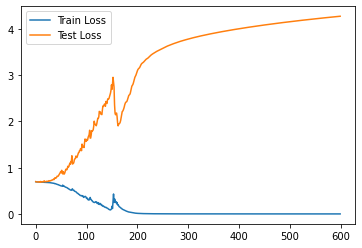

In [207]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend();

In [210]:
# Get accuracy
with torch.no_grad():
  # Train accuracy
  Ptrain = model(Xtrain)
  Ptrain = (Ptrain.cpu().numpy() > 0)
  train_acc = np.mean(Ytrain.cpu().numpy() == Ptrain)

  # Test accuracy
  Ptest = model(Xtest)
  Ptest = (Ptest.cpu().numpy() > 0)
  test_acc = np.mean(Ytest.cpu().numpy() == Ptest)

# Test prediction is approximately 0.5, bad model. 
# Train accuracy is 1. It is clearly overfitting.
print(f"Train Accuracy:{train_acc:.4f}, Test Accuracy:{test_acc:.4f}")

Train Accuracy:1.0000, Test Accuracy:0.5146
